## Data set creation

Genome tag data is taken from movie lens.

In [ ]:
#import packages
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import requests
import configparser
import pickle

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import squareform

import time
import collections
from PIL import Image
import sys

In [2]:
#import key for tmdb API
config = configparser.ConfigParser()
config.read('API_KEYS.ini')
config.sections()

API_KEY = config['tmdb.com']['API_KEY']

tmdb.API_KEY = API_KEY

In [3]:
#import data
genome_tags_ids = pd.read_csv('data/genome-tags.csv')
movies = pd.read_csv('data/movies.csv')
genome_tags = pd.read_csv('data/genome-scores.csv')
user_tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

In [5]:
#create movie lookup table
movies = movies.merge(links, left_on = 'movieId', right_on = 'movieId', how = 'left')
movies.dropna(subset=['tmdbId'], inplace=True)
movies['tmdbId'] = movies['tmdbId'].astype(int)
movies.loc[movies['movieId'] == 4207, 'tmdbId'] = 427910
movies.loc[movies['movieId'] == 4568, 'tmdbId'] = 207340
movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357
4,5,Father of the Bride Part II (1995),Comedy,113041,11862


In [7]:
#create genome tag data; 1 record per movie per tag 
genome_tags = genome_tags.merge(genome_tags_ids, left_on = 'tagId', right_on = 'tagId', how = 'left')
genome_tags = genome_tags.merge(movies[['title', 'movieId', 'tmdbId']], left_on = 'movieId', right_on = 'movieId', how = 'left')
genome_tags = genome_tags[genome_tags['tmdbId'].notnull()]
genome_tags['tmdbId'] = genome_tags['tmdbId'].astype(int)
genome_tags.head()

,movieId,tagId,relevance,tag,title,tmdbId
0,1,1,0.02475,007,Toy Story (1995),862
1,1,2,0.02475,007 (series),Toy Story (1995),862
2,1,3,0.04900,18th century,Toy Story (1995),862
3,1,4,0.07750,1920s,Toy Story (1995),862
4,1,5,0.12450,1930s,Toy Story (1995),862


In [8]:
#Only 10982 movies with genome tags
len(genome_tags['movieId'].unique())

10982

## Generate Tag Data

There are over 10000 tags per movie.  To reduce the number of tags to review, we do the following:

1. Restrict tags to those that are among top 5 tags for at least 100 movies
2. Remove tags that are not relevant to image analysis (ie: 007, franchise, oscar, etc)
3. Cluster correlated tags together

We end up with 44 tags mostly indicating movie genre

In [9]:
#get top 5 tags per movie
top5 = genome_tags.sort_values(by=['movieId', 'relevance', 'tagId'], ascending = [True, False, True]).groupby('movieId').head(5)
top5.head()

,movieId,tagId,relevance,tag,title,tmdbId
1035,1,1036,0.99925,toys,Toy Story (1995),862
243,1,244,0.99875,computer animation,Toy Story (1995),862
785,1,786,0.99525,pixar animation,Toy Story (1995),862
588,1,589,0.99125,kids and family,Toy Story (1995),862
63,1,64,0.98650,animation,Toy Story (1995),862


[Text(0,0,'computer animation'),
 Text(0,0,'kids and family'),
 Text(0,0,'animation'),
 Text(0,0,'adventure'),
 Text(0,0,'children'),
 Text(0,0,'kids'),
 Text(0,0,'special effects'),
 Text(0,0,'good sequel'),
 Text(0,0,'sequel'),
 Text(0,0,'sequels'),
 Text(0,0,'comedy'),
 Text(0,0,'original'),
 Text(0,0,'women'),
 Text(0,0,'chick flick'),
 Text(0,0,'girlie movie'),
 Text(0,0,'romantic'),
 Text(0,0,'unlikely friendships'),
 Text(0,0,'crime'),
 Text(0,0,'gunfight'),
 Text(0,0,'great acting'),
 Text(0,0,'remake'),
 Text(0,0,'romantic comedy'),
 Text(0,0,'romance'),
 Text(0,0,'based on a book'),
 Text(0,0,'childhood'),
 Text(0,0,'adapted from:book'),
 Text(0,0,'action'),
 Text(0,0,'good action'),
 Text(0,0,'franchise'),
 Text(0,0,'espionage'),
 Text(0,0,'politics'),
 Text(0,0,'political'),
 Text(0,0,'spoof'),
 Text(0,0,'parody'),
 Text(0,0,'silly fun'),
 Text(0,0,'biographical'),
 Text(0,0,'biopic'),
 Text(0,0,'gangsters'),
 Text(0,0,'storytelling'),
 Text(0,0,'weird'),
 Text(0,0,'goofy')

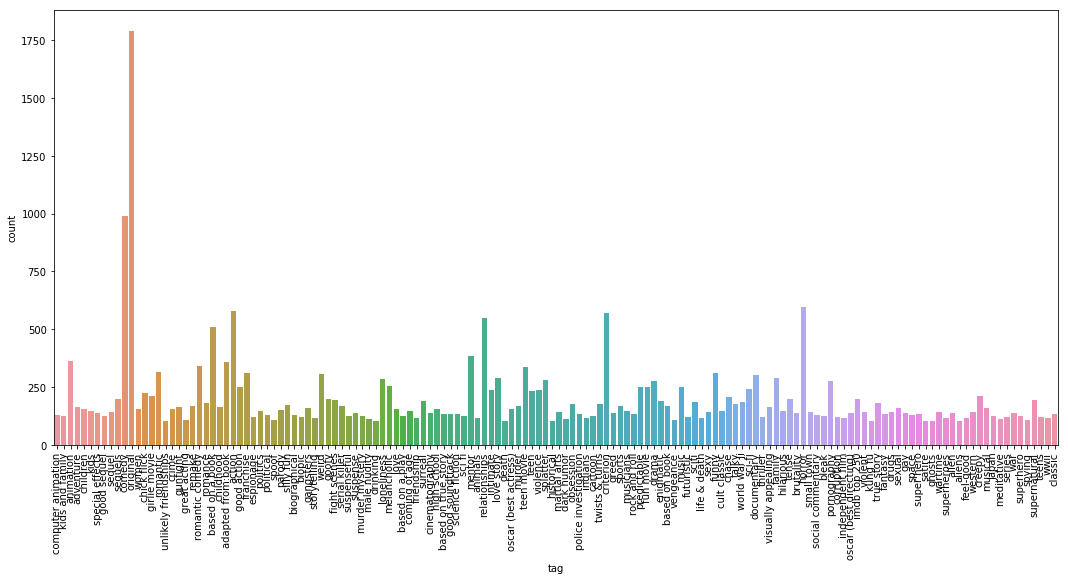

In [10]:
#Get list of top 5 tags
tagslist = top5.tag.value_counts()
tagslist = tagslist[tagslist > 100]
tagslist = list(tagslist.index.values)  

top5 = top5.loc[top5['tag'].isin(tagslist)]

fig, ax = plt.subplots(figsize=(18,8))
ax = sns.countplot(x = "tag", data = top5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [11]:
#keep tags that are in top5 for any movie
genome_tags = genome_tags.loc[genome_tags['tag'].isin(tagslist)]
genome_tags = genome_tags.pivot(index='movieId', columns='tag', values='relevance')
genome_tags.columns = map(str.lower, genome_tags.columns)
genome_tags.columns = genome_tags.columns.str.replace(' ', '_')

In [12]:
#drop tags that should not be predicted based on picture
genome_tags.columns.values

drop_cols = ['adapted_from:book',
             'based_on_a_book', 
             'based_on_a_play',
             'based_on_book', 
             'based_on_true_story', 
             'cinematography', 
             'classic',
             'computer_animation',
             'criterion', 
             'cult_classic',
             'franchise', 
             'good_sequel', 
             'good_soundtrack',
             'great_acting',
             'imdb_top_250', 
             'male_nudity', 
             'original',
             'oscar_(best_actress)', 
             'oscar_(best_directing)', 
             'parody',
             'predictable', 
             'remake',
             'sequel', 
             'sequels',
             'series',
             'special_effects',
             'storytelling']
genome_tags.drop(columns = drop_cols, inplace = True)

In [13]:
#examine genome tag data
genome_tags.head()

,action,adventure,alien,aliens,animals,animation,biographical,biopic,bleak,brutality,...,violence,violent,visually_appealing,war,wartime,weird,western,women,world_war_ii,wwii
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.65025,0.89800,0.13850,0.25350,0.69200,0.98650,0.11625,0.09975,0.11750,0.24150,...,0.28350,0.19600,0.40675,0.06375,0.09200,0.32300,0.02275,0.10850,0.04300,0.03600
2,0.62825,0.97975,0.03725,0.05575,0.91150,0.13725,0.08475,0.05375,0.04975,0.23100,...,0.17100,0.13450,0.18850,0.04175,0.04625,0.30275,0.01275,0.12750,0.01650,0.01325
3,0.15575,0.42900,0.03100,0.04250,0.09125,0.02650,0.04350,0.03450,0.06850,0.29825,...,0.11575,0.10175,0.21950,0.03675,0.06600,0.17125,0.03500,0.37375,0.02650,0.01725
4,0.13825,0.12975,0.02375,0.02975,0.13075,0.04450,0.03150,0.03175,0.05075,0.31475,...,0.17225,0.09125,0.18425,0.03250,0.05425,0.16725,0.03000,0.97575,0.02150,0.01325
5,0.15475,0.15250,0.03225,0.03500,0.12850,0.02675,0.05625,0.03800,0.06125,0.26600,...,0.10500,0.08375,0.19375,0.03400,0.05700,0.25750,0.02400,0.46200,0.01875,0.01325


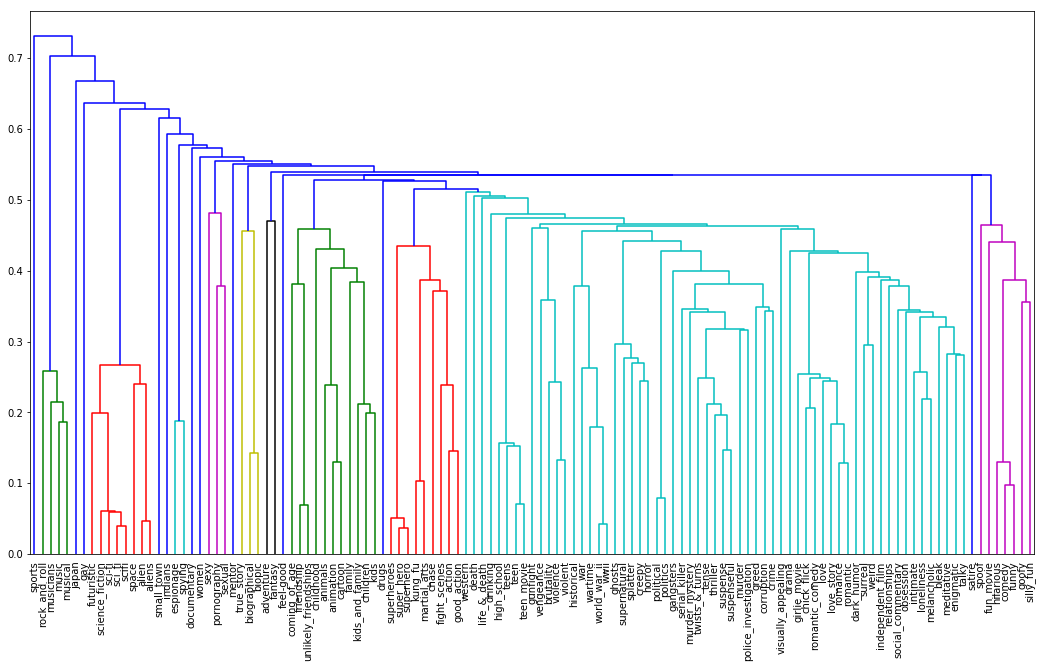

In [14]:
#get correlation matrix for each tag
corr = genome_tags.corr()

#change to distance matrix using 
corr = 1- corr
corr.head()

cond_dist = squareform(corr)

Z = linkage(cond_dist)
fig, ax = plt.subplots(figsize=(18, 10))
g = dendrogram(Z, ax = ax, labels=corr.index)
ax.tick_params(axis = 'x', which = 'major', labelsize = 10)
plt.show()

In [15]:
#set cut point at 0.4
cutree = cut_tree(Z, height = 0.40)
cutree = np.reshape(cutree, -1)

In [16]:
#name tag clusters
var_clusters = pd.DataFrame({'tag' : corr.index,
                            'cluster': cutree})
var_clusters.sort_values(by = 'cluster')
cluster_tags = {
    0: 'action',
    1: 'adventure',
    2: 'scifi',
    3: 'animation',
    4: 'biopic',
    5: 'melancholic_wierd',
    6: 'violent',
    7: 'romance',
    8: 'childhood', 
    9: 'family',
    10: 'comedy', 
    11: 'friendships', 
    12: 'crime',
    13: 'horror', 
    14: 'death', 
    15: 'documentary', 
    16: 'drama', 
    17: 'drugs', 
    18: 'drinking',
    19: 'spy',
    20: 'fantasy', 
    21: 'feel_good',
    22: 'fun', 
    23: 'gangsters', 
    24: 'gay',
    25: 'gunfight',
    26: 'teen', 
    27: 'war',
    28: 'indians', 
    29: 'japan', 
    30: 'life_death',
    31: 'mentor', 
    32: 'music', 
    33: 'political', 
    34: 'sexual', 
    35: 'satire', 
    36: 'sexy', 
    37: 'smalltown', 
    38: 'spoof', 
    39: 'sports', 
    40: 'superhero', 
    41: 'true story', 
    42: 'visual',
    43: 'western',
    44: 'women'
}

topics = list(cluster_tags.values())

In [17]:
#reduce tags to max value per cluster
genome_tags = pd.melt(genome_tags.reset_index(), id_vars = 'movieId', var_name='tag', value_name='relevance')
genome_tags = genome_tags.merge(var_clusters, left_on = 'tag', right_on = 'tag', how = "left")
genome_tags = pd.DataFrame(genome_tags.groupby(['movieId', 'cluster'])['relevance'].max()).reset_index()
genome_tags['cluster_label'] = genome_tags.cluster.map(cluster_tags)
genome_tags = genome_tags.pivot(index='movieId', columns='cluster_label', values='relevance')

In [18]:
#create master tags dataset with title and linking IDs
genome_tags = genome_tags.merge(movies[['title', 'tmdbId', 'movieId']] , left_index = True, right_on = 'movieId', how = 'left')

Create a dataset where tags are binary columns.  Cutuff for scores are arbitrarily set at 0.75

In [410]:
#make genome tags binary; anything with score > 0.75 is true
genome_tags_binary = genome_tags.drop(['title', 'tmdbId', 'movieId'], axis = 1) > 0.75
genome_tags_binary[['movieId', 'title', 'tmdbId']] = genome_tags[['movieId','title', 'tmdbId']]
genome_tags_binary[topics] = genome_tags_binary[topics] *1
genome_tags_binary.head()

,action,adventure,animation,biopic,childhood,comedy,crime,death,documentary,drama,...,teen,true story,violent,visual,war,western,women,movieId,title,tmdbId
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Toy Story (1995),862
1,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,Jumanji (1995),8844
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,Grumpier Old Men (1995),15602
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,Waiting to Exhale (1995),31357
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,Father of the Bride Part II (1995),11862


In [61]:
#review movies per tag
genome_tags_binary[topics].sum(axis = 0).sort_values(ascending = False)

melancholic_wierd    3641.0
crime                2260.0
comedy               1605.0
action               1535.0
violent              1265.0
romance              1235.0
mentor               1228.0
drama                1072.0
horror               1037.0
visual                843.0
family                822.0
scifi                 706.0
war                   643.0
sexual                638.0
fun                   627.0
friendships           624.0
teen                  617.0
animation             578.0
childhood             548.0
music                 494.0
adventure             425.0
documentary           383.0
true story            360.0
feel_good             357.0
political             355.0
gunfight              344.0
life_death            319.0
biopic                312.0
gangsters             297.0
sexy                  293.0
fantasy               290.0
drugs                 275.0
death                 260.0
women                 255.0
spy                   246.0
smalltown           

In [22]:
#get tags per movie
genome_tags_binary[topics].sum(axis = 1).mean()

2.615734838827172

## Generate Image Data

The movie posters can be obtained through The Movie Database (tmdb) API.  

In [23]:
#use tmdb API to get poster URLs per movie
#this step can take 2+ hours

def get_rgb(url):
    try:
        resp = requests.get(url, stream=True).raw
        
    except requests.exceptions.RequestException as e:  
        sys.exit(1)
        
    try:
        img = Image.open(resp)
        
    except IOError:
        print("Unable to open image")
        sys.exit(1)
        
    #translate to rgb array; shape = rows x columns x channels
    image_rgb = np.array(img)
    
    return image_rgb

posters = collections.defaultdict(dict)
for i in genome_tags_binary['tmdbId']:
    try:
        #api call to get movie poster path
        movie = tmdb.Movies(i)
        movie.info()
    
    except requests.exceptions.HTTPError:
        print("tmbdId %s doesn't exist" %i)
        posters[i]['tmdbId_exist'] = 0
        continue
    
    else:
        posters[i]['tmdbId_exist'] = 1
        posters[i]['poster_path'] = movie.info()['poster_path']
        posters[i]['title'] = movie.info()['title']

tmbdId 68149 doesn't exist
tmbdId 24549 doesn't exist
tmbdId 14980 doesn't exist
tmbdId 164721 doesn't exist
tmbdId 140207 doesn't exist
tmbdId 192936 doesn't exist
tmbdId 876 doesn't exist
tmbdId 149645 doesn't exist
tmbdId 8677 doesn't exist
tmbdId 13057 doesn't exist
tmbdId 119324 doesn't exist
tmbdId 2670 doesn't exist
tmbdId 13519 doesn't exist
tmbdId 152426 doesn't exist
tmbdId 30983 doesn't exist
tmbdId 7096 doesn't exist
tmbdId 15738 doesn't exist
tmbdId 11944 doesn't exist
tmbdId 110147 doesn't exist
tmbdId 206216 doesn't exist
tmbdId 64699 doesn't exist
tmbdId 69234 doesn't exist
tmbdId 13716 doesn't exist
tmbdId 11343 doesn't exist
tmbdId 10700 doesn't exist
tmbdId 24019 doesn't exist
tmbdId 58923 doesn't exist
tmbdId 17266 doesn't exist
tmbdId 253768 doesn't exist
tmbdId 27138 doesn't exist
tmbdId 14305 doesn't exist
tmbdId 13541 doesn't exist
tmbdId 225130 doesn't exist
tmbdId 114796 doesn't exist
tmbdId 13905 doesn't exist
tmbdId 14301 doesn't exist
tmbdId 67479 doesn't e

In [24]:
#get URLS for each poster
posters_df = pd.DataFrame.from_dict(posters, orient = 'index')
posters_df.loc[posters_df['poster_path'].notnull(), 'full_path'] = "https://image.tmdb.org/t/p/w300" + posters_df['poster_path']
posters_df.loc[posters_df['poster_path'].notnull(), 'rgb'] = posters_df.loc[posters_df['poster_path'].notnull(),'full_path'].apply(get_rgb)
posters_df.index.rename('tmdbId', inplace = True)
posters_df.reset_index(inplace = True)

In [ ]:
#pickle poster URLs
with open('posters_url.pickle', 'wb') as handle:
    pickle.dump(posters_df[['tmdbId', 'tmdbId_exist', 'title', 'full_path']], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [250]:
posters_df['full_path'][0]

'https://image.tmdb.org/t/p/w300/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg'

In [62]:
#merge poster data with tags
posters_df = pd.merge(posters_df, genome_tags_binary[['tmdbId'] + topics], left_on = 'tmdbId', right_on = 'tmdbId', how = 'left')

In [295]:
#only 10904 movies with poster data
posters_df['full_path'].notnull().sum()

10904

In [297]:
#download images to local folder
import urllib.request 

for index, i in posters_df[posters_df['full_path'].notnull()].iterrows():
    img_path = 'data/images/poster_tmdbid_' + str(i['tmdbId']) + '.jpg'
    urllib.request.urlretrieve(i['full_path'], img_path)

## Transfer learning from vgg16

In [244]:
from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss

In [411]:
x_train, x_test, y_train, y_test = train_test_split(posters_df.loc[posters_df['full_path'].notnull(), 'tmdbId'], 
                                                    posters_df.loc[posters_df['full_path'].notnull(), 'action'],
                                                    test_size=0.33, random_state=42)

In [412]:
#converting train images to array and applying mean subtraction processing
train_img=[]
for i in x_train[:10]:

    temp_img=image.load_img('data/images/poster_tmdbid_' + str(i) + '.jpg',target_size=(224,224))
    temp_img=np.array(temp_img)
    train_img.append(temp_img)

train_img = np.array(train_img)
train_img=preprocess_input(train_img)

In [345]:
# applying the same procedure with the test dataset

test_img=[]
for i in x_test:

    temp_img=image.load_img('data/images/poster_tmdbid_' + str(i) + '.jpg',target_size=(224,224))
    temp_img=np.array(temp_img)
    test_img.append(temp_img)

test_img = np.array(test_img)
test_img=preprocess_input(test_img)

In [429]:
# loading VGG16 model weights
model = VGG16(weights='imagenet', include_top=False)
print("model structure: ", model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [ ]:
# Extracting features from the train dataset using the VGG16 pre-trained model
features_train=model.predict(train_img)

# Extracting features from the train dataset using the VGG16 pre-trained model
features_test=model.predict(test_img)

In [397]:
##Save features extracted from posters

#pickle test features
with open('features_train_vgg16.pickle', 'wb') as handle:
    pickle.dump(features_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

#pickle train features
with open('features_test_vgg16.pickle', 'wb') as handle:
    pickle.dump(features_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [352]:
# flattening the layers to conform to MLP input
train_x=features_train.reshape(7305,25088)

# flattening the layers to conform to MLP input
test_x=features_test.reshape(3599,25088)


In [388]:
y_train, y_test = train_test_split(posters_df.loc[posters_df['full_path'].notnull(), 'melancholic_wierd'], test_size=0.33, random_state=42)
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.33045859000684463
0.33203667685468186


In [389]:
# converting target variable to array
train_y=np.asarray(y_train)

# performing one-hot encoding for the target variable
train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)

# converting target variable to array
test_y=np.asarray(y_test)

# performing one-hot encoding for the target variable
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)

In [419]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

#creating a mlp model
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=25088, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(250,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fitting the model 
model.fit(train_x, train_y, epochs=20, batch_size=128,validation_data=(test_x,test_y), callbacks=[history])

Train on 7305 samples, validate on 3599 samples
Epoch 1/20
7305/7305 [==============================] - 25s 3ms/step - loss: 0.6455 - acc: 0.6657 - val_loss: 0.6332 - val_acc: 0.6680
Epoch 2/20
7305/7305 [==============================] - 25s 3ms/step - loss: 0.6374 - acc: 0.6695 - val_loss: 0.6348 - val_acc: 0.6680
Epoch 3/20
7305/7305 [==============================] - 25s 3ms/step - loss: 0.6339 - acc: 0.6695 - val_loss: 0.6575 - val_acc: 0.6680
Epoch 4/20
7305/7305 [==============================] - 24s 3ms/step - loss: 0.6390 - acc: 0.6698 - val_loss: 0.6368 - val_acc: 0.6680
Epoch 5/20
7305/7305 [==============================] - 24s 3ms/step - loss: 0.6353 - acc: 0.6695 - val_loss: 0.6337 - val_acc: 0.6680
Epoch 6/20
7305/7305 [==============================] - 24s 3ms/step - loss: 0.6362 - acc: 0.6698 - val_loss: 0.6357 - val_acc: 0.6680
Epoch 7/20
7305/7305 [==============================] - 23s 3ms/step - loss: 0.6363 - acc: 0.6695 - val_loss: 0.6432 - val_acc: 0.6680
Epoch 8

Test loss: 0.6186655503108985
Test accuracy: 0.6676854682684144


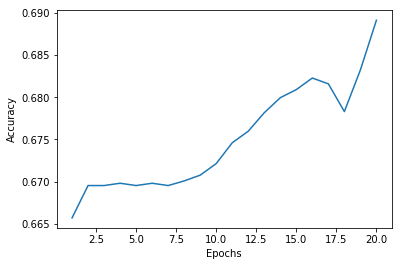

In [420]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 21), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [423]:
test_pred = (model.predict(test_x))
(test_pred> 0.5).sum(axis = 0)

array([3390,  209])

In [424]:
test_pred

array([[0.7345763 , 0.26542372],
       [0.5606164 , 0.43938366],
       [0.77740246, 0.22259751],
       ...,
       [0.6230485 , 0.37695143],
       [0.54000944, 0.4599905 ],
       [0.60365427, 0.3963457 ]], dtype=float32)

## Transfer Learning from Inception

In [425]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [434]:
x_train, x_test, y_train, y_test = train_test_split(posters_df.loc[posters_df['full_path'].notnull(), 'tmdbId'], 
                                                    posters_df.loc[posters_df['full_path'].notnull(), 'action'],
                                                    test_size=0.33, random_state=42)

In [440]:
#converting train images to array and applying mean subtraction processing
train_img=[]
for i in x_train:

    temp_img=image.load_img('data/images/poster_tmdbid_' + str(i) + '.jpg',target_size=(299,299))
    temp_img=np.array(temp_img)
    train_img.append(temp_img)

train_img = np.array(train_img)
train_img=preprocess_input(train_img)

In [441]:
# applying the same procedure with the test dataset

test_img=[]
for i in x_test:

    temp_img=image.load_img('data/images/poster_tmdbid_' + str(i) + '.jpg',target_size=(299,299))
    temp_img=np.array(temp_img)
    test_img.append(temp_img)

test_img = np.array(test_img)
test_img=preprocess_input(test_img)

In [443]:
model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 10s 0us/step


In [444]:
print("model structure: ", model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_197 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_197[0][0]                 
__________________________________________________________________________________________________
activation_205 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_198

In [445]:
# Extracting features from the train dataset using the inception pre-trained model
features_train=model.predict(train_img)

# Extracting features from the train dataset using the inception pre-trained model
features_test=model.predict(test_img)

In [451]:
# flattening the layers to conform to MLP input
train_x=features_train.reshape(7305,131072)

# flattening the layers to conform to MLP input
test_x=features_test.reshape(3599,131072)

In [447]:
# converting target variable to array
train_y=np.asarray(y_train)

# performing one-hot encoding for the target variable
train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)

# converting target variable to array
test_y=np.asarray(y_test)

# performing one-hot encoding for the target variable
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)

In [453]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

#creating a mlp model
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=131072, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fitting the model 
model.fit(train_x, train_y, epochs=20, batch_size=128,validation_data=(test_x,test_y), callbacks=[history])

Train on 7305 samples, validate on 3599 samples
Epoch 1/20
7305/7305 [==============================] - 158s 22ms/step - loss: 0.4438 - acc: 0.8472 - val_loss: 0.4045 - val_acc: 0.8611
Epoch 2/20
7305/7305 [==============================] - 144s 20ms/step - loss: 0.4087 - acc: 0.8595 - val_loss: 0.4031 - val_acc: 0.8611
Epoch 3/20
7305/7305 [==============================] - 143s 20ms/step - loss: 0.4120 - acc: 0.8595 - val_loss: 0.4040 - val_acc: 0.8611
Epoch 4/20
7305/7305 [==============================] - 125s 17ms/step - loss: 0.4099 - acc: 0.8595 - val_loss: 0.4068 - val_acc: 0.8611
Epoch 5/20
7305/7305 [==============================] - 122s 17ms/step - loss: 0.4105 - acc: 0.8595 - val_loss: 0.4042 - val_acc: 0.8611
Epoch 6/20
7305/7305 [==============================] - 145s 20ms/step - loss: 0.4073 - acc: 0.8595 - val_loss: 0.4031 - val_acc: 0.8611
Epoch 7/20
7305/7305 [==============================] - 148s 20ms/step - loss: 0.4069 - acc: 0.8595 - val_loss: 0.4035 - val_acc: 

Test loss: 0.40301305525135284
Test accuracy: 0.8610725201610461


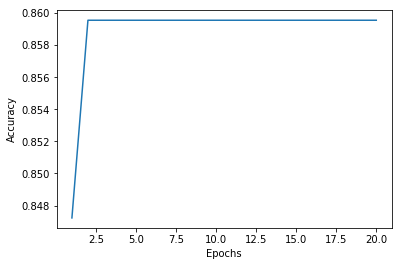

In [454]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 21), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()